# Import

In [1]:
# generic
import matplotlib.pyplot as plt
import numpy as np

# custom
import obj
import processing

# Toggles

In [2]:
is_kernel = True
is_conv = True
is_fft = True

# Helper

In [3]:
def fuzz(image, ranges, p=0.15):
    rows, cols = image.shape
    for row in range(rows):
        for col in range(cols):
            if(np.random.uniform() < p):
                image[row][col] += np.random.randint(-ranges, ranges)

In [4]:
# vectorized
def magnitude(cimage):
    return np.sqrt(np.power(cimage.re, 2) + np.power(cimage.im, 2))

def logTransform(spectrum):
    return np.log10(spectrum)

# Setup

Image size:  (32, 32)


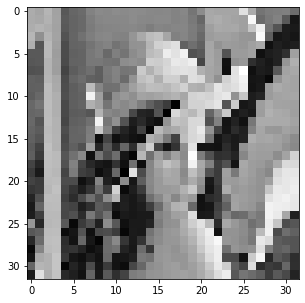

In [5]:
if is_fft or is_conv or is_kernel:
    test_path = './test.png'
    size = 32
    img = obj.Image(test_path, size)
    print("Image size: ", img.data.shape)
    plt.rcParams["figure.figsize"] = (5,5)
    plt.imshow(img.data, cmap ='gray')

# Kernel Test

In [6]:
if is_kernel:
    # create ad populate kernel
    kernel = obj.Kernel(3)
    kernel.generateFilter(3)

    print("Generated Filter")
    print(kernel.data)
    print("Sum:", np.sum(kernel.data))
    print('\n')
    print("Pretty Generated Filter")
    print(kernel.data / np.min(kernel.data))
    print("Sum:", np.sum(kernel.data))

Generated Filter
[[0.1069973  0.11310982 0.1069973 ]
 [0.11310982 0.11957153 0.11310982]
 [0.1069973  0.11310982 0.1069973 ]]
Sum: 1.0


Pretty Generated Filter
[[1.         1.05712774 1.        ]
 [1.05712774 1.11751907 1.05712774]
 [1.         1.05712774 1.        ]]
Sum: 1.0


# Convolution Test

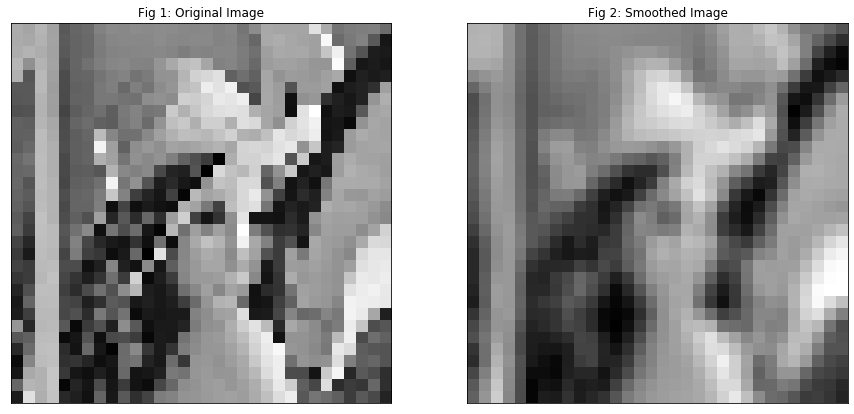

In [7]:
if is_conv:   
    img_in = obj.Image(test_path, size)
    img_out = obj.Image(test_path, size)
    img_out.clear()

    processing.convolve(img_in, img_out, kernel)

    plt.rcParams["figure.figsize"] = (15,15)
    plt.subplot(121), plt.imshow(img_in.data, cmap='gray')
    plt.title("Fig 1: Original Image"), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(img_out.data,  cmap='gray')
    plt.title("Fig 2: Smoothed Image"), plt.xticks([]), plt.yticks([])
    plt.show()

# Fourier Test

In [8]:
if is_fft:
    cimg_in = obj.CImage(test_path, size)
    cimg_out = obj.CImage(test_path, size)
    img_rev = obj.Image(test_path, size)
    img_rev.clear()
    cimg_out.clear()

    processing.fft(cimg_in, cimg_out)

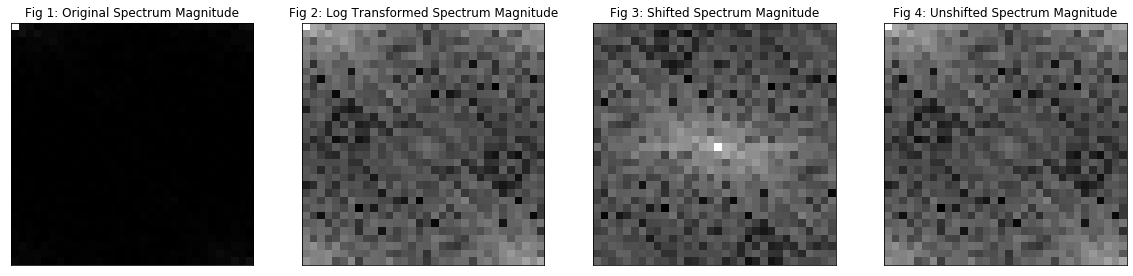

In [9]:
if is_fft:
    spectrum = magnitude(cimg_out)
    scale_spectrum = logTransform(spectrum)
    shift_spectrum = processing.quickShift(scale_spectrum)
    unshift_spectrum = processing.quickShift(shift_spectrum)
    
    plt.rcParams["figure.figsize"] = (20,20)
    plt.subplot(141), plt.imshow(spectrum, cmap='gray')
    plt.title("Fig 1: Original Spectrum Magnitude"), plt.xticks([]), plt.yticks([])
    plt.subplot(142), plt.imshow(scale_spectrum,  cmap='gray')
    plt.title("Fig 2: Log Transformed Spectrum Magnitude"), plt.xticks([]), plt.yticks([])
    plt.subplot(143), plt.imshow(shift_spectrum,  cmap='gray')
    plt.title("Fig 3: Shifted Spectrum Magnitude"), plt.xticks([]), plt.yticks([])
    plt.subplot(144), plt.imshow(unshift_spectrum,  cmap='gray')
    plt.title("Fig 4: Unshifted Spectrum Magnitude"), plt.xticks([]), plt.yticks([])
    plt.show()

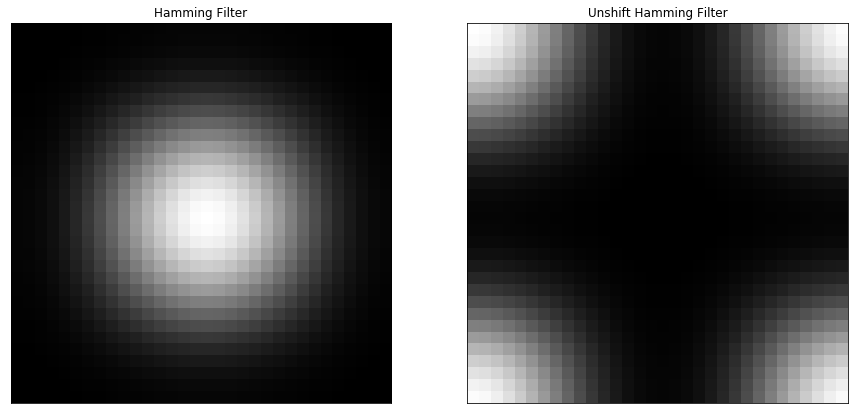

In [10]:
if is_fft:
    c_filter = obj.Hamming(size)
    c_filter.generateFilter(3)
    
    shift_filter = processing.quickShift(c_filter.data)
    
    plt.rcParams["figure.figsize"] = (15,15)
    plt.subplot(121),plt.imshow(c_filter.data, cmap='gray')
    plt.title("Hamming Filter"), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(shift_filter, cmap='gray')
    plt.title("Unshift Hamming Filter"), plt.xticks([]), plt.yticks([])
    plt.show()

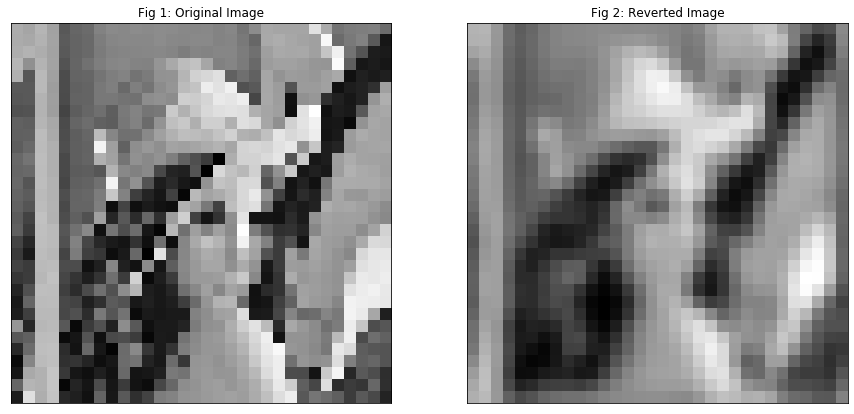

In [11]:
if is_fft:
    c_filter.data = shift_filter
    processing.lowpass(cimg_out, c_filter)
    processing.ifft(cimg_out, img_rev)

    plt.rcParams["figure.figsize"] = (15,15)
    plt.subplot(121), plt.imshow(cimg_in.re, cmap='gray')
    plt.title("Fig 1: Original Image"), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(img_rev.data,  cmap='gray')
    plt.title("Fig 2: Reverted Image"), plt.xticks([]), plt.yticks([])
    plt.show()